In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Problem Definition

Summarize short text into headlines

The dataset consists of 4515 examples and contains Author_name, Headlines, Url of Article, Short text, Complete Article. Gathered the summarized news from Inshorts and only scraped the news articles from Hindu, Indian times and Guardian. Time period ranges from febrauary to august 2017.

# Exploration Data Analysis

## Importing Libraries

In [1]:
pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=bfe2d32ff05098320eafed920273cf80a31154200f218c328fe3546a6f3e29ef
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Attention
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
from tensorflow.keras.utils import plot_model
import rouge_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Loading Data

In [3]:
summary = pd.read_csv('/kaggle/input/news-summary/news_summary.csv', encoding='iso-8859-1')
summary_more = pd.read_csv('/kaggle/input/news-summary/news_summary_more.csv', encoding='iso-8859-1')

In [4]:
display(summary.head(1))

,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in offices order,http://www.hindustantimes.com/india-news/rakshabandhan-compulsory-in-daman-and-diu-women-employees-to-tie-rakhis-to-male-colleagues/story-E5h5U1ZDJii5zFpLXWRkhJ.html?utm_source=inshorts&utm_medium...,The Administration of Union Territory Daman and Diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on the occasion of Rakshabandhan on August 7. The...,The Daman and Diu administration on Wednesday withdrew a circular that asked women staff to tie rakhis on male colleagues after the order triggered a backlash from employees and was ripped apart o...


In [5]:
summary_more.head(1)

,headlines,text
0,upGrad learner switches to career in ML & Al with 90% salary hike,"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program ..."


In [6]:
summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4514 entries, 0 to 4513
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   author     4514 non-null   object
 1   date       4514 non-null   object
 2   headlines  4514 non-null   object
 3   read_more  4514 non-null   object
 4   text       4514 non-null   object
 5   ctext      4396 non-null   object
dtypes: object(6)
memory usage: 211.7+ KB


In [7]:
summary_more.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98401 entries, 0 to 98400
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   headlines  98401 non-null  object
 1   text       98401 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [8]:
df=summary[['headlines','text']]

In [9]:
df_test = summary_more[['headlines','text']].head(1000)

## Data Preprocessing

In [10]:
stop_words = set(stopwords.words('english')) 

def text_cleaner(text,num=0):
    # lower
    newString = text.lower()
    # remove HTML
    newString = BeautifulSoup(newString, "lxml").text
    # Remove any text inside the parenthesis
    newString = re.sub(r'\([^)]*\)', '', newString)
    # remove double quotes
    newString = re.sub('"','', newString)
    # remove 's
    newString = re.sub(r"'s\b","",newString)
    # Eliminate punctuations and special characters
    newString = re.sub("[^a-zA-Z]", " ", newString)
    # Remove stopwords
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    # Remove short words
    for i in tokens:
        if len(i)>1:                                                 
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [11]:
df['cleaned_summary']=df['headlines'].apply(text_cleaner)
df['cleaned_text']=df['text'].apply(text_cleaner)
df_test['cleaned_summary']=df_test['headlines'].apply(text_cleaner)
df_test['cleaned_text']=df_test['text'].apply(text_cleaner)

In [12]:
#Replacing empty string summaries with nan values and then dropping those datapoints.
df['cleaned_summary'].replace('', np.nan, inplace=True)
df.dropna(axis=0, inplace=True)
df_test['cleaned_summary'].replace('', np.nan, inplace=True)
df_test.dropna(axis=0, inplace=True)

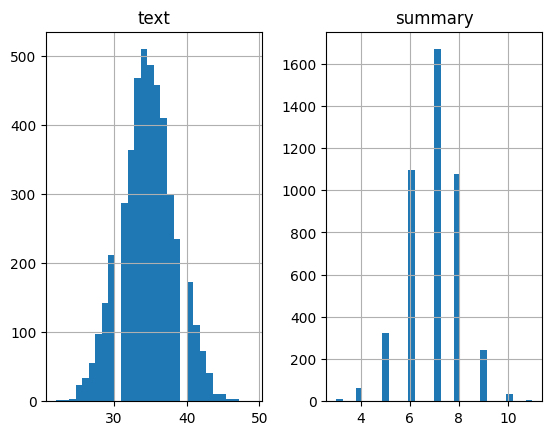

In [13]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in df['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in df['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [14]:
def clean_text (df):
    cleaned_text =np.array(df['cleaned_text'])
    cleaned_summary=np.array(df['cleaned_summary'])
    return pd.DataFrame({'text':cleaned_text,'summary':cleaned_summary})

In [15]:
train = clean_text(df)
test = clean_text(df_test)

In [16]:
#Get max length of texts and summaries.
max_text_len = max([len(text.split()) for text in train['text']])
max_summary_len = max([len(text.split()) for text in train['summary']])
print(max_text_len, max_summary_len)

49 11


In [90]:
train['summary'] = train['summary'].apply(lambda x : 'sostok '+ x + ' eostok')
test['summary'] = test['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

We used the start token sostok and the end token eostok. This is important because the model will learn that all the summaries start with ‘sostok’ and end with ‘eostok’. 

In [91]:
from sklearn.model_selection import train_test_split 
X = train['text']
y = train['summary']
X_train,X_validation,y_train,y_validation=train_test_split(np.array(X),np.array(y),test_size=0.2,random_state=15)
X_test = np.array(test['text'])
y_test = np.array(test['summary'])

# Base model - Seq2Seq LSTM

In [92]:
def a_tokenizer(df_train,df_val,max_length):
    tokenizer=Tokenizer()
    tokenizer.fit_on_texts(list(df_train)) #updates internal vocabulary based on a list of texts. It will create a dictionary with word mapping with an index(unique numerical value)
    #convert text sequences into integer sequences 
    #transforms each text in texts to a sequence of numerical value. It will give assign the index of each to the word. The output will be series of numerical value
    train_seq = tokenizer.texts_to_sequences(df_train) 
    val_seq = tokenizer.texts_to_sequences(df_val)
    #padding zero upto maximum length
    train = pad_sequences(train_seq,  maxlen=max_length, padding='post')
    val = pad_sequences(val_seq, maxlen=max_length, padding='post')
    #size of vocabulary ( +1 for padding token)
    voc= len(tokenizer.word_index) + 1
    print(print("Size of vocabulary = {}".format(voc)))
    return tokenizer,train, val,voc

In [93]:
X_tokenizer,X_tr, X_val, X_voc = a_tokenizer(X_train,X_validation,max_text_len)

Size of vocabulary = 16612
None


In [94]:
y_tokenizer,y_tr,y_val,y_voc = a_tokenizer(y_train,y_validation,max_summary_len)

Size of vocabulary = 7329
None


## Model Building

In [95]:
import tensorflow as tf
from tensorflow.python.keras import backend as K

logger = tf.get_logger()

class AttentionLayer(tf.keras.layers.Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs

        logger.debug(f"encoder_out_seq.shape = {encoder_out_seq.shape}")
        logger.debug(f"decoder_out_seq.shape = {decoder_out_seq.shape}")

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            logger.debug("Running energy computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_full_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim

            logger.debug(f"U_a_dot_h.shape = {U_a_dot_h.shape}")

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)

            logger.debug(f"Ws_plus_Uh.shape = {Ws_plus_Uh.shape}")

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            logger.debug(f"ei.shape = {e_i.shape}")

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            logger.debug("Running attention vector computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_full_seq * K.expand_dims(inputs, -1), axis=1)

            logger.debug(f"ci.shape = {c_i.shape}")

            return c_i, [c_i]

        # we don't maintain states between steps when computing attention
        # attention is stateless, so we're passing a fake state for RNN step function
        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e], constants=[encoder_out_seq]
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c], constants=[encoder_out_seq]
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]


In [96]:
from keras import backend as K 
K.clear_session() 
embedding_dim = 90 #Size of word embeddings.
latent_dim = 250 #No. of neurons in LSTM layer.

# Encoder 
encoder_inputs = Input(shape=(max_text_len,), name="encoder_input") 
enc_emb = Embedding(X_voc, embedding_dim,trainable=True,name="encoder_embeding")(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 
#encoder_outputs, state_h, state_c= encoder_lstm3(enc_emb) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,),name="decoder_input") 
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim,return_sequences=True, return_state=True, dropout=0.2, recurrent_dropout=0.4) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention Layer 
attention_layer = AttentionLayer(name="attention_layer")
attention_outputs, attention_state = attention_layer([encoder_outputs, decoder_outputs])

# concatinate decoder and attention otuputs 
decoder_concat = Concatenate(axis=-1, name="decoder_concat")([decoder_outputs, attention_outputs])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 49)]         0           []                               
                                                                                                  
 encoder_embeding (Embedding)   (None, 49, 90)       1495080     ['encoder_input[0][0]']          
                                                                                                  
 lstm (LSTM)                    [(None, 49, 250),    341000      ['encoder_embeding[0][0]']       
                                 (None, 250),                                                     
                                 (None, 250)]                                                     
                                                                                              

In [97]:
##using sparse categorical cross-entropy as the loss function since it converts the integer sequence to a one-hot vector on the fly. This overcomes any memory issues.
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy') #Root Mean Squared Propagation
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.15, patience=2, min_lr=0.0001)

In [98]:
history = model.fit([X_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:], batch_size=15, epochs=20, validation_data=([X_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]), callbacks=[es,reduce_lr])

Epoch 1/20
241/241 [==============================] - 42s 127ms/step - loss: 6.2522 - val_loss: 5.0709 - lr: 0.0010
Epoch 2/20
241/241 [==============================] - 19s 80ms/step - loss: 5.8640 - val_loss: 4.9064 - lr: 0.0010
Epoch 3/20
241/241 [==============================] - 19s 80ms/step - loss: 5.8205 - val_loss: 4.8875 - lr: 0.0010
Epoch 4/20
241/241 [==============================] - 18s 75ms/step - loss: 5.7744 - val_loss: 4.8722 - lr: 0.0010
Epoch 5/20
241/241 [==============================] - 18s 76ms/step - loss: 5.7097 - val_loss: 4.8370 - lr: 0.0010
Epoch 6/20
241/241 [==============================] - 18s 76ms/step - loss: 5.6461 - val_loss: 4.7788 - lr: 0.0010
Epoch 7/20
241/241 [==============================] - 18s 73ms/step - loss: 5.6022 - val_loss: 4.7931 - lr: 0.0010
Epoch 8/20
241/241 [==============================] - 18s 74ms/step - loss: 5.5524 - val_loss: 4.7740 - lr: 0.0010
Epoch 9/20
241/241 [==============================] - 18s 74ms/step - loss: 5.5

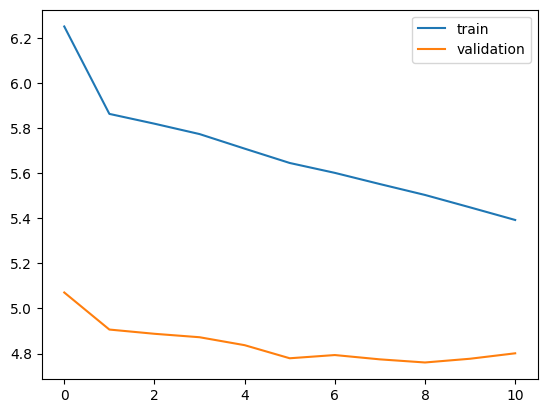

In [100]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.legend()
pyplot.show()

## Model testing and Evaluation

In [101]:
import pickle
# save the tokenizer 
with open('xtokenizer.pickle', 'wb') as handle:
    pickle.dump(X_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('ytokenizer.pickle', 'wb') as handle:
    pickle.dump(y_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [102]:
# set tokenizerz for predictions
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=X_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [103]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb_pred= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs_p, state_h_p, state_c_p = decoder_lstm(dec_emb_pred, initial_state=[decoder_state_input_h, decoder_state_input_c])

# Attention
attention_out_inference, attention_state_inference = attention_layer([decoder_hidden_state_input, decoder_outputs_p])
decoder_concat = Concatenate(axis=-1, name="concat_attention")([decoder_outputs_p, attention_out_inference])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_final_outputs = decoder_dense(decoder_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_final_outputs] + [state_h_p, state_c_p])

In [104]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq, verbose=None)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # predict token
        predict_token_index = np.argmax(output_tokens[0, -1, :])
        predict_token = reverse_target_word_index[predict_token_index]
        
        if(predict_token!='eostok'):
            decoded_sentence += ' '+predict_token

        # Exit condition: either hit max length or find stop word.
        if (predict_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = predict_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [105]:
X_test_seq = X_tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_text_len, padding="post")
y_test_seq = y_tokenizer.texts_to_sequences(y_test)
y_test_pad = pad_sequences(y_test_seq, maxlen=max_summary_len, padding="post")

In [106]:
#define the functions to convert an integer sequence to a word sequence for summary 
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+" "
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+" "
    return newString

In [108]:
for i in range(5):
    print('News:', X_test[i])
    print('Actual Headline:', y_test[i])
    print('Predicted Headline:', decode_sequence(X_test_pad[i].reshape(1, max_text_len)))

News: saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers
Actual Headline: sostok upgrad learner switches career ml al salary hike eostok
1/1 [==============================] - 0s 24ms/step
Predicted Headline:  india india india says says says
News: kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit
Actual Headline: sostok delhi techie wins free food swiggy one year cred eostok
1/1 [==============================] - 0s 23ms/step
Predicted Headline:  india india india india india
News: new zealand defeated india wickets fourth odi hamilton t

In [109]:
%%capture --no-display
predicted = []
for i in range(len(X_test)):
    predicted.append(decode_sequence(X_test_pad[i].reshape(1, max_text_len)).split())

In [129]:
summaries = list(y_test)
references = []
for summ in summaries:
    ref = summ.split()
    ref.remove('eostok')
    ref.remove('sostok')
    references.append(ref)

In [130]:
lstm_predicted = pd.DataFrame({'summary':references,'generated_summary':predicted})

In [131]:
lstm_predicted['summary'] = lstm_predicted['summary'].str.join(" ")
lstm_predicted['generated_summary'] = lstm_predicted['generated_summary'].str.join(" ")

In [132]:
lstm_predicted.head()

,summary,generated_summary
0,upgrad learner switches career ml al salary hike,india india india says says says
1,delhi techie wins free food swiggy one year cred,india india india india india
2,new zealand end rohit sharma led india match winning streak,kohli kohli kohli kohli film film film
3,aegon life iterm insurance plan helps customers save tax,india india india india says says
4,known hirani yrs metoo claims true sonam,akshay kohli world says says


In [133]:
def calculate_rouge(data):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    data["r1_fscore"] = data.apply(lambda row : scorer.score(row["summary"],row["generated_summary"])['rouge1'][2], axis=1)
    data["r2_fscore"] = data.apply(lambda row : scorer.score(row["summary"],row["generated_summary"])['rouge2'][2], axis=1)
    data["rl_fscore"] = data.apply(lambda row : scorer.score(row["summary"],row["generated_summary"])['rougeL'][2], axis=1)
    return data

score_ret=calculate_rouge(lstm_predicted)

print("ROUGE - 1 : ",score_ret["r1_fscore"].mean())
print("ROUGE - 2 : ",score_ret["r2_fscore"].mean())
print("ROUGE - L : ",score_ret["rl_fscore"].mean())

ROUGE - 1 :  0.024607843953432188
ROUGE - 2 :  0.0022635947385947386
ROUGE - L :  0.024474510620098856


# T5 Transformer

In [19]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

# Importing the T5 modules from huggingface/transformers
from transformers import T5Tokenizer, T5ForConditionalGeneration

In [20]:
# # Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [21]:
# Creating a custom dataset for reading the dataframe and loading it into the dataloader to pass it to the neural network at a later stage for finetuning the model and to prepare it for predictions
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, source_len, summ_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.source_len = source_len
        self.summ_len = summ_len
        self.text = self.data.text
        self.headlines = self.data.headlines

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = ' '.join(text.split())

        summary = str(self.headlines[index])
        summary = ' '.join(summary.split())

        source = self.tokenizer.batch_encode_plus([text], max_length= self.source_len, pad_to_max_length=True,return_tensors='pt')
        target = self.tokenizer.batch_encode_plus([summary], max_length= self.summ_len, pad_to_max_length=True,return_tensors='pt')

        source_ids = source['input_ids'].squeeze()
        source_mask = source['attention_mask'].squeeze()
        target_ids = target['input_ids'].squeeze()
        target_mask = target['attention_mask'].squeeze()

        return {
            'source_ids': source_ids.to(dtype=torch.long), 
            'source_mask': source_mask.to(dtype=torch.long), 
            'target_ids': target_ids.to(dtype=torch.long),
            'target_ids_y': target_ids.to(dtype=torch.long)
        }

Fine Tuning the Model: Function

In [22]:
# Creating the training function. This will be called in the main function. It is run depending on the epoch value.
# The model is put into train mode and then we numerate over the training loader and passed to the defined network 
def train(epoch, tokenizer, model, device, loader, optimizer):
    model.train()
    for _,data in enumerate(loader, 0):
        y = data['target_ids'].to(device, dtype = torch.long)
        y_ids = y[:, :-1].contiguous()
        lm_labels = y[:, 1:].clone().detach()
        lm_labels[y[:, 1:] == tokenizer.pad_token_id] = -100
        ids = data['source_ids'].to(device, dtype = torch.long)
        mask = data['source_mask'].to(device, dtype = torch.long)

        outputs = model(input_ids = ids, attention_mask = mask, decoder_input_ids=y_ids, labels=lm_labels)
        loss = outputs[0]
        
        if _%100==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Validating the Model Performance: Function

In [17]:
def validate(epoch, tokenizer, model, device, loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for _, data in enumerate(loader, 0):
            y = data['target_ids'].to(device, dtype = torch.long)
            ids = data['source_ids'].to(device, dtype = torch.long)
            mask = data['source_mask'].to(device, dtype = torch.long)

            generated_ids = model.generate(
                input_ids = ids,
                attention_mask = mask, 
                max_length=150, 
                num_beams=2,
                repetition_penalty=2.5, 
                length_penalty=1.0, 
                early_stopping=True
                )
            preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
            target = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True)for t in y]
            if _%100==0:
                print(f'Completed {_}')

            predictions.extend(preds)
            actuals.extend(target)
    return predictions, actuals

In [23]:
TRAIN_BATCH_SIZE = 2    # input batch size for training (default: 64)
VALID_BATCH_SIZE = 2    # input batch size for testing (default: 1000)
TRAIN_EPOCHS = 2        # number of epochs to train (default: 10)
VAL_EPOCHS = 1 
LEARNING_RATE = 1e-4    # learning rate (default: 0.01)
SEED = 15              # random seed

# Set random seeds and deterministic pytorch for reproducibility
torch.manual_seed(SEED) # pytorch random seed
np.random.seed(SEED) # numpy random seed
torch.backends.cudnn.deterministic = True

# tokenzier for encoding the text
tokenizer = T5Tokenizer.from_pretrained("t5-base")


# Importing and Pre-Processing the domain data
# Selecting the needed columns only. 
# Adding the summarzie text in front of the text. This is to format the dataset similar to how T5 model was trained for summarization task. 
df_train = df[['text','headlines']]
df_train.text = 'summarize: ' + df_train.text

df_test = df_test[['text','headlines']]
df_test.text = 'summarize' + df_test.text

# Creation of Dataset and Dataloader
# Defining the train size. So 80% of the data will be used for training and the rest will be used for validation. 
train_size = 0.8
train_dataset=df_train.sample(frac=train_size, random_state = SEED).reset_index(drop=True)
val_dataset=df_train.drop(train_dataset.index).reset_index(drop=True)

print("FULL Dataset: {}".format(df_train.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("Validation Dataset: {}".format(val_dataset.shape))
print('Text Dataset : {}'.format(df_test.shape))

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. If you see this, DO NOT PANIC! This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


FULL Dataset: (4514, 2)
TRAIN Dataset: (3611, 2)
Validation Dataset: (903, 2)
Text Dataset : (1000, 2)


In [24]:
# Creating the Training and Validation dataset for further creation of Dataloader
training_set = CustomDataset(train_dataset, tokenizer, max_text_len, max_summary_len)
val_set = CustomDataset(val_dataset, tokenizer, max_text_len, max_summary_len)
test_set =  CustomDataset(df_test, tokenizer, max_text_len, max_summary_len)
# Defining the parameters for creation of dataloaders
train_params = {
    'batch_size': TRAIN_BATCH_SIZE,
    'shuffle': True,
    'num_workers': 0
    }

val_params = {
    'batch_size': VALID_BATCH_SIZE,
    'shuffle': False,
    'num_workers': 0
    }

# Creation of Dataloaders for testing and validation. This will be used down for training and validation stage for the model.
training_loader = DataLoader(training_set, **train_params)
val_loader = DataLoader(val_set, **val_params)
test_loader = DataLoader (test_set, **val_params)

In [25]:
# Defining the model. We are using t5-base model and added a Language model layer on top for generation of Summary. 
# Further this model is sent to device (GPU/TPU) for using the hardware.
model = T5ForConditionalGeneration.from_pretrained("t5-base")
model = model.to(device)

# Defining the optimizer that will be used to tune the weights of the network in the training session. 
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

# Training loop
print('Initiating Fine-Tuning for the model on our dataset')

for epoch in range(TRAIN_EPOCHS):
    train(epoch, tokenizer, model, device, training_loader, optimizer)
    #train(epoch,tokenzier,model,device,val_loader,optimizer)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Initiating Fine-Tuning for the model on our dataset
Epoch: 0, Loss:  7.258360862731934
Epoch: 0, Loss:  3.2665698528289795
Epoch: 0, Loss:  2.33552622795105
Epoch: 0, Loss:  3.1891794204711914
Epoch: 0, Loss:  1.965980887413025
Epoch: 0, Loss:  2.669278621673584
Epoch: 0, Loss:  2.984703540802002
Epoch: 0, Loss:  1.8937631845474243
Epoch: 0, Loss:  2.2124156951904297
Epoch: 0, Loss:  2.9236392974853516
Epoch: 0, Loss:  2.3356661796569824
Epoch: 0, Loss:  2.3376195430755615
Epoch: 0, Loss:  1.4691359996795654
Epoch: 0, Loss:  1.9940359592437744
Epoch: 0, Loss:  2.040010929107666
Epoch: 0, Loss:  2.5996530055999756
Epoch: 0, Loss:  1.244724988937378
Epoch: 0, Loss:  0.9348486661911011
Epoch: 0, Loss:  3.1507134437561035
Epoch: 1, Loss:  0.6395046710968018
Epoch: 1, Loss:  1.4232113361358643
Epoch: 1, Loss:  1.171932339668274
Epoch: 1, Loss:  1.4015607833862305
Epoch: 1, Loss:  0.7478516697883606
Epoch: 1, Loss:  1.4645543098449707
Epoch: 1, Loss:  0.5528285503387451
Epoch: 1, Loss:  0.81

In [26]:

print('Now generating summaries on our fine tuned model for the test dataset and saving it in a dataframe')
for epoch in range(VAL_EPOCHS):
    predictions, actuals = validate(epoch, tokenizer, model, device, test_loader)
    t5_predict = pd.DataFrame({'generated_summary':predictions,'summary':actuals})

Now generating summaries on our fine tuned model for the validation dataset and saving it in a dataframe
Completed 0
Completed 100
Completed 200
Completed 300
Completed 400


In [33]:
from rouge_score import rouge_scorer
def calculate_rouge(data):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    data["r1_fscore"] = data.apply(lambda row : scorer.score(row["summary"],row["generated_summary"])['rouge1'][2], axis=1)
    data["r2_fscore"] = data.apply(lambda row : scorer.score(row["summary"],row["generated_summary"])['rouge2'][2], axis=1)
    data["rl_fscore"] = data.apply(lambda row : scorer.score(row["summary"],row["generated_summary"])['rougeL'][2], axis=1)
    return data

In [34]:
score_ret_t5=calculate_rouge(t5_predict)

print("ROUGE - 1 : ",score_ret_t5["r1_fscore"].mean())
print("ROUGE - 2 : ",score_ret_t5["r2_fscore"].mean())
print("ROUGE - L : ",score_ret_t5["rl_fscore"].mean())

ROUGE - 1 :  0.3734031999762959
ROUGE - 2 :  0.19183872692024329
ROUGE - L :  0.3512792881144631


In [35]:
t5_predict.head()

,generated_summary,summary,r1_fscore,r2_fscore,rl_fscore
0,"alumnus of upGrad, IIIT-B",upGrad learner switches to career in,0.181818,0.000000,0.181818
1,KUNAL Shah's credit card bill payment platform gave users a chance to win free food from Swiggy,Delhi techie wins free food from Swi,0.320000,0.260870,0.320000
2,New Zealand defeat India by 8 wickets in the fourth ODI at Hamilton,New Zealand end Rohit Sharma-led India',0.300000,0.111111,0.300000
3,Aegon Life iTerm Insurance plan provides tax benefits on premiums paid,Aegon life iTerm insurance plan helps,0.588235,0.533333,0.588235
4,"Speaking about Rajkumar's sexual harassment allegations against Hirani, Sonam",Have known Hirani for yrs,0.133333,0.000000,0.133333
